In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import json
import pickle

# Load the datasets
vis_main = fits.open('../data/vis_main.fits')[1].data

df = pd.DataFrame(np.array(vis_main).byteswap().newbyteorder())

In [2]:
import sys
import os

src_path = os.path.abspath("../src")
sys.path.insert(0, src_path)

import pandas as pd
from tqdm import tqdm
from bic_vs_components import compute_bic_vs_n_components
from gmm_analysis import fit_gmm_fixed_components, plot_gmm_with_contributions, extract_gmm_parameters


/Users/raunaqrai/miniforge3/envs/research_project_MW_GMM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

def define_alpha_sequences(df, alpha_col='aom_xp', feh_col='mh_xgboost'):
    alpha = df[alpha_col]
    feh = df[feh_col]

    high_alpha = (
        ((feh < -0.6) & (alpha > 0.28)) |
        ((feh >= -0.6) & (feh <= 0.125) & (alpha > (-0.25 * feh + 0.13))) |
        ((feh > 0.125) & (alpha > 0.1))
    )

    low_alpha = (
        ((feh < -0.8) & (alpha < 0.21)) |
        ((feh >= -0.8) & (feh <= 0.07) & (alpha < (-0.21 * feh + 0.045))) |
        ((feh > 0.07) & (alpha < 0.03))
    )

    return df[high_alpha], df[low_alpha]

def plot_vr_vphi_by_metallicity(df, title_prefix, save_prefix=None):
    # Define metallicity bins and labels
    metallicity_bins = [-3.0, -2.0, -1.6, -1.3, -1.0, -0.7, -0.4, 0.0, 0.5]
    bin_labels = [
        "-3.0 < [M/H] < -2.0", "-2.0 < [M/H] < -1.6", "-1.6 < [M/H] < -1.3", "-1.3 < [M/H] < -1.0",
        "-1.0 < [M/H] < -0.7", "-0.7 < [M/H] < -0.4", "-0.4 < [M/H] < 0.0", "0.0 < [M/H] < 0.5"
    ]

    bins = 100
    x_limits = (-400, 400)
    y_limits = (-400, 400)

    fig, axes = plt.subplots(2, 4, figsize=(15, 9), constrained_layout=True)

    for i, (low, high) in enumerate(zip(metallicity_bins[:-1], metallicity_bins[1:])):
        df_filtered = df[(df["mh_xgboost"] > low) & (df["mh_xgboost"] <= high)]
        df_filtered = df_filtered.dropna(subset=["v_R", "v_phi"])

        # Compute 2D histogram
        H, xedges, yedges = np.histogram2d(
            df_filtered["v_R"],
            df_filtered["v_phi"],
            bins=bins, range=[x_limits, y_limits], density=True
        )

        # Min-max normalization
        H_min = np.min(H[H > 0]) if np.any(H > 0) else 1e-5
        H_max = np.max(H) if np.max(H) > 0 else 1
        H_normalized = (H - H_min) / (H_max - H_min)
        H_normalized = np.clip(H_normalized, 0, 1)

        ax = axes[i // 4, i % 4]
        im = ax.pcolormesh(xedges, yedges, H_normalized.T, cmap="Greys", shading='auto')

        ax.set_title(f"{title_prefix}\n{bin_labels[i]}", fontsize=11)
        ax.set_xlabel(r"$v_R$ (km/s)", fontsize=10)
        ax.set_ylabel(r"$v_\phi$ (km/s)", fontsize=10)
        ax.tick_params(axis="both", labelsize=9)
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.text(x_limits[0] + 20, y_limits[0] + 20, f"Sample size: {len(df_filtered)}", fontsize=9)

    if save_prefix:
        plt.savefig(f"../figures/{save_prefix}.png", dpi=300)
    plt.show()

# Define high and low alpha populations
df_high, df_low = define_alpha_sequences(df)

In [4]:
df_vmp_high = df_high[(df_high['mh_xgboost'] >= -3.0) & (df_high['mh_xgboost'] < -2.0)]
df_imp_high = df_high[(df_high['mh_xgboost'] >= -2.0) & (df_high['mh_xgboost'] < -1.6)]
df_mp1_high = df_high[(df_high['mh_xgboost'] >= -1.6) & (df_high['mh_xgboost'] < -1.3)]
df_mp2_high = df_high[(df_high['mh_xgboost'] >= -1.3) & (df_high['mh_xgboost'] < -1.0)]

df_vmp_low = df_low[(df_low['mh_xgboost'] >= -3.0) & (df_low['mh_xgboost'] < -2.0)]
df_imp_low = df_low[(df_low['mh_xgboost'] >= -2.0) & (df_low['mh_xgboost'] < -1.6)]
df_mp1_low = df_low[(df_low['mh_xgboost'] >= -1.6) & (df_low['mh_xgboost'] < -1.3)]
df_mp2_low = df_low[(df_low['mh_xgboost'] >= -1.3) & (df_low['mh_xgboost'] < -1.0)]

Fitting GMM with 5 components: 100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


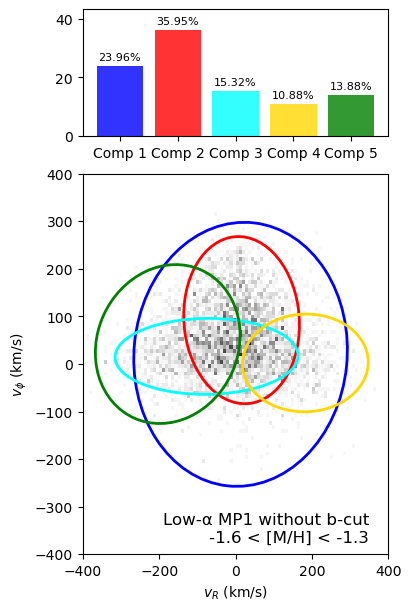


Low-α MP2 (-1.6 < [M/H] < -1.3) (7630 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     10.9      182.70     82.33      2.26        51.36      10.01    109.95  
  Prograde halo     15.3      -76.05    119.74     16.11        39.91      13.48     74.52  
         GS/E 1     24.0       13.03    139.83     20.37       138.74       6.20    131.90  
         GS/E 2     13.9     -177.70     94.75     42.01        83.52     -44.41     89.42  
     Thick Disc     36.0       15.71     75.74     92.27        87.84       2.55     65.28  


In [7]:
#mp1 low alpha component 5

gmm_mp1_low = fit_gmm_fixed_components(df_mp1_low, n_components=5, n_init=50)

plot_gmm_with_contributions(
    df_bin=df_mp1_low,
    gmm=gmm_mp1_low,
    bin_label="Low-α MP1 without b-cut",
    metallicity_range="-1.6 < [M/H] < -1.3",
    label="mp1_low_alpha_without_b_cut"
)

summary = extract_gmm_parameters(gmm_mp1_low, df_mp1_low, label="Low-α MP2 (-1.6 < [M/H] < -1.3)")
print(summary)


Fitting GMM with 6 components:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting GMM with 6 components: 100%|██████████| 50/50 [04:18<00:00,  5.17s/it]


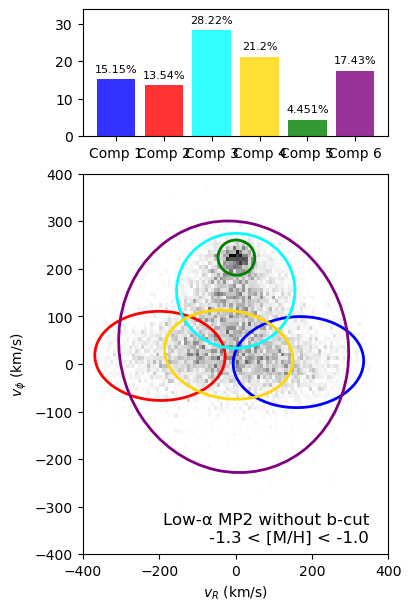


Low-α MP2 (-1.3 < [M/H] < -1.0) (16518 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     15.2      164.47     85.41       4.05       47.84     -11.82    108.62  
  Prograde halo     13.5     -197.97     85.32      17.09       46.85       0.69    102.12  
         GS/E 1     21.2      -17.83     84.05      19.75       46.83      -0.07     61.11  
         GS/E 2     17.4       -4.99    150.57      36.30      132.22       1.38    129.39  
     Thick Disc     28.2        0.40     77.45     153.97       60.33      -0.76     60.59  
    Component 6      4.5        2.13     24.10     223.70       18.49       3.39     12.32  


In [ ]:
gmm_mp2_low = fit_gmm_fixed_components(df_mp2_low, n_components=6, n_init=50)


plot_gmm_with_contributions(
    df_bin=df_mp2_low,
    gmm=gmm_mp2_low,    
    bin_label="Low-α MP2 without b-cut",
    metallicity_range="-1.3 < [M/H] < -1.0",
    label="mp2_low_alpha_without_b_cut"
)

summary = extract_gmm_parameters(gmm_mp2_low, df_mp2_low, label="Low-α MP2 (-1.3 < [M/H] < -1.0)")
print(summary)